# Aktuell Beispiel der Maschine uno

In [99]:
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report

# Daten einlesen

data = pd.read_pickle("../data/PdM_merged_preprocessed.pkl")
scaler = pd.read_pickle("../data/scaler.pkl")

# Filtern der Maschine 1
data = data[data['machineID'] == 1]

data['datetime'] = pd.to_datetime(data['datetime'])

data = data.sort_values(by=['machineID', 'datetime'])
data['comp_replaced'] = (data['comp'] != 0).astype(int)

import numpy as np

data['time_to_next_replacement'] = np.nan

for machine in data['machineID'].unique():
    machine_data = data[data['machineID'] == machine]
    replacement_times = machine_data[machine_data['comp_replaced'] == 1]['datetime']

    if replacement_times.empty:
        continue

    replacement_times = pd.to_datetime(replacement_times)
    next_replacement = replacement_times.iloc[0]

    for idx, row in machine_data.iterrows():
        if row['datetime'] >= next_replacement:
            future_replacements = replacement_times[replacement_times > row['datetime']]
            if not future_replacements.empty:
                next_replacement = future_replacements.iloc[0]
            else:
                break  # Kein weiterer Austausch
        time_delta = (next_replacement - row['datetime']).total_seconds() / 3600  # in Stunden
        data.loc[idx, 'time_to_next_replacement'] = time_delta

features = ['volt', 'rotate', 'pressure', 'vibration', 'age']

In [100]:
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_absolute_error, mean_squared_error
import joblib

# Load the scaler object
scaler = joblib.load('../data/scaler.pkl')

# Set NaN values in the target variable to -1 (außer für die letzten Zeilen)
data['time_to_next_replacement'].fillna(-1, inplace=True)

y = data['time_to_next_replacement']
X_clean = data[features] # Use the same scaler to transform the data

X_train, X_test, y_train, y_test = train_test_split(X_clean, y, test_size=0.2, random_state=42)

model = RandomForestRegressor(n_estimators=100, random_state=42)
model.fit(X_train, y_train)
y_pred = model.predict(X_test)

mae = mean_absolute_error(y_test, y_pred)
rmse = np.sqrt(mean_squared_error(y_test, y_pred))

print(f'Mean Absolute Error (MAE): {mae}')
print(f'Root Mean Squared Error (RMSE): {rmse}')


/home/EnzoZ/.local/lib/python3.10/site-packages/sklearn/base.py:376: InconsistentVersionWarning: Trying to unpickle estimator MinMaxScaler from version 1.3.0 when using version 1.5.2. This might lead to breaking code or invalid results. Use at your own risk. For more info please refer to:
https://scikit-learn.org/stable/model_persistence.html#security-maintainability-limitations
  warnings.warn(
/tmp/ipykernel_4057233/4127119371.py:9: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  data['time_to_next_replacement'].fillna(-1, inp

Mean Absolute Error (MAE): 103.50168091168092
Root Mean Squared Error (RMSE): 126.06051437143093


In [101]:
# Aktuelle Sensordaten erfassen (z.B. aus einer Datenbank oder direkt von den Sensoren)
# Hier ein Beispiel-Datenpunkt
current_data = pd.DataFrame({
    'volt': [170.0],
    'rotate': [420.0],
    'pressure': [100.0],
    'vibration': [40.0],
    'age': [18]
})

# Die gleichen Vorverarbeitungsschritte anwenden wie beim Training
X_current = scaler.transform(current_data[features])

# Vorhersage der verbleibenden Nutzungsdauer
rul_prediction = model.predict(X_current)

print(f'Vorhergesagte verbleibende Nutzungsdauer: {rul_prediction[0]:.2f} Stunden')

Vorhergesagte verbleibende Nutzungsdauer: 208.85 Stunden


/home/EnzoZ/.local/lib/python3.10/site-packages/sklearn/base.py:493: UserWarning: X does not have valid feature names, but RandomForestRegressor was fitted with feature names
  warnings.warn(


Hier kann ein Schwellwert festgelegt werden, ab wann das PM-System Alarm schlägt und eine Wartung empfiehlt (z. B: wenn die verbleibende Nutzdauer dreimal unter 50 Stunden fällt).

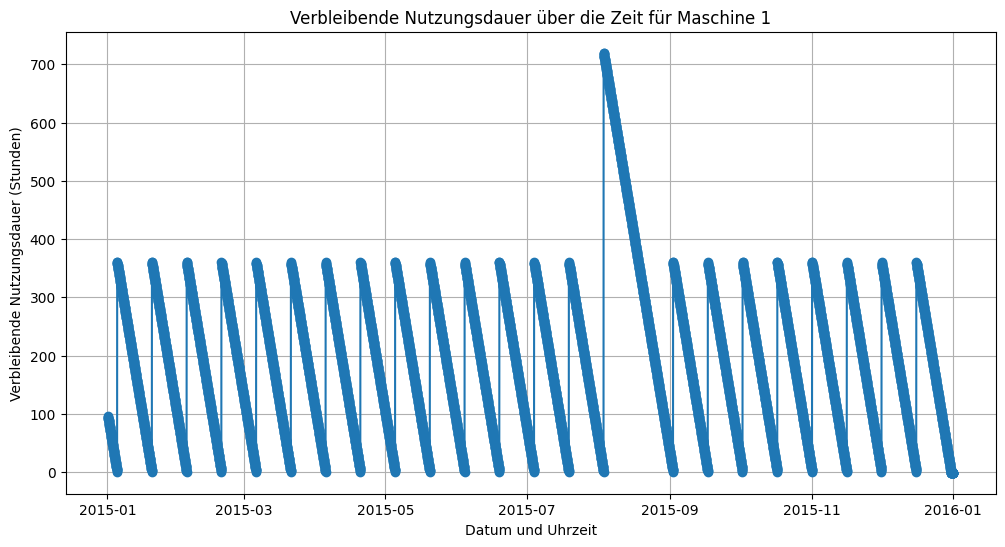

In [102]:
import matplotlib.pyplot as plt
import pandas as pd

plt.figure(figsize=(12,6))
plt.plot(data['datetime'], data['time_to_next_replacement'], marker='o')
plt.title(f'Verbleibende Nutzungsdauer über die Zeit für Maschine {1}')
plt.xlabel('Datum und Uhrzeit')
plt.ylabel('Verbleibende Nutzungsdauer (Stunden)')
plt.grid(True)
plt.show()


In [103]:
# Erstelle eine linerae Regression zur Vorhersage der verbleibenden Nutzungsdauer
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import train_test_split


# Annahme: 'data' ist Ihr DataFrame mit den Spalten 'volt', 'rotate', 'pressure', 'vibration', 'age' und 'time_to_next_replacement'

X = data[['volt', 'rotate', 'pressure', 'vibration', 'age']]
y = data['time_to_next_replacement']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=1)

model = LinearRegression()
model.fit(X_train, y_train)
y_pred = model.predict(X_test)

# Ausgabe der Funktion
print(f'Funktion: y = {model.coef_[0]:.2f}*volt + {model.coef_[1]:.2f}*rotate + {model.coef_[2]:.2f}*pressure + {model.coef_[3]:.2f}*vibration + {model.coef_[4]:.2f}*age + {model.intercept_:.2f}')


Funktion: y = -19.74*volt + 25.37*rotate + 62.02*pressure + -59.05*vibration + -106.20*age + 286.61


Funktion: y = -20.40*volt + 44.05*rotate + 71.14*pressure + -47.69*vibration + 91.68*age + 91.70

Wenn Volt größer wird, wir die Lebensdauer verringert. Zu geringe rotate Werte und Druck Werte führen zu einer Verringerung der Lebensdauer. Zu hohe Vibrationen führen zu einer Verringerung der Lebensdauer. Zu hohe Alter führen zu einer Verringerung der Lebensdauer. ETC

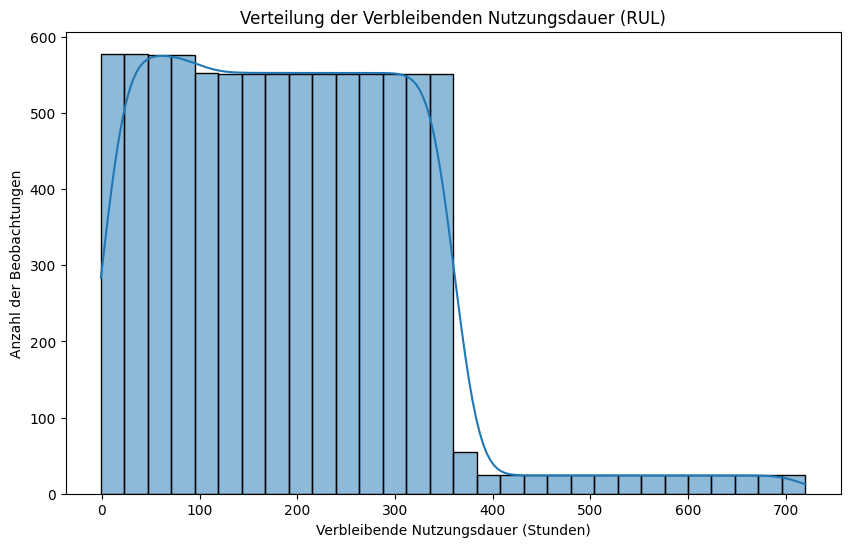

In [104]:
import seaborn as sns

plt.figure(figsize=(10,6))
sns.histplot(data['time_to_next_replacement'], bins=30, kde=True)
plt.title('Verteilung der Verbleibenden Nutzungsdauer (RUL)')
plt.xlabel('Verbleibende Nutzungsdauer (Stunden)')
plt.ylabel('Anzahl der Beobachtungen')
plt.show()


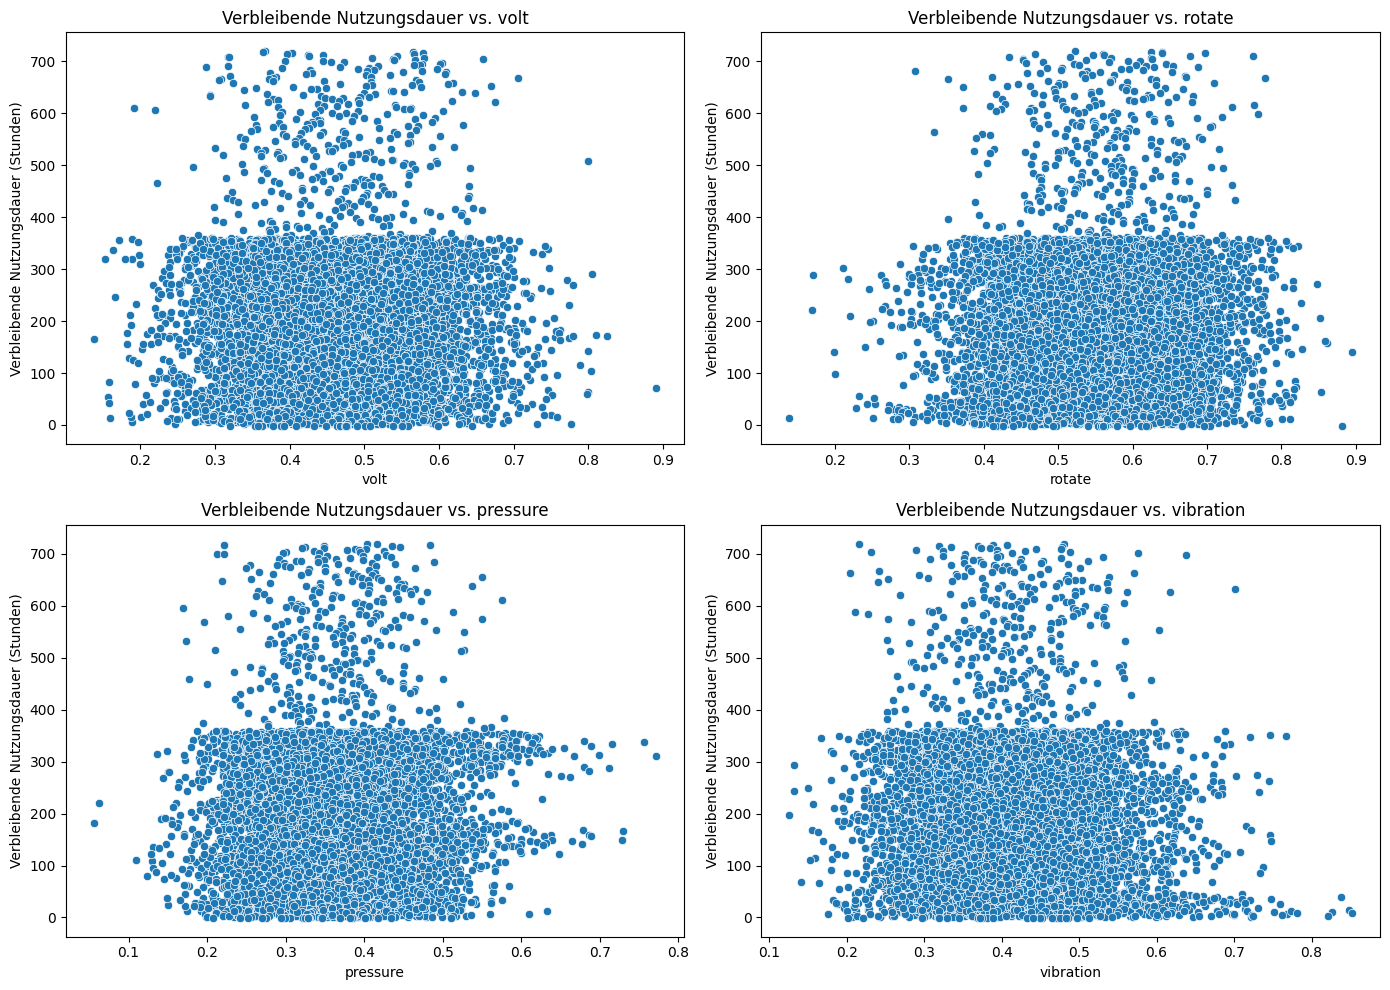

In [105]:
features = ['volt', 'rotate', 'pressure', 'vibration']

fig, axes = plt.subplots(2, 2, figsize=(14, 10))
axes = axes.flatten()

for i, feature in enumerate(features):
    sns.scatterplot(x=feature, y='time_to_next_replacement', data=data, ax=axes[i])
    axes[i].set_title(f'Verbleibende Nutzungsdauer vs. {feature}')
    axes[i].set_xlabel(feature)
    axes[i].set_ylabel('Verbleibende Nutzungsdauer (Stunden)')

plt.tight_layout()
plt.show()


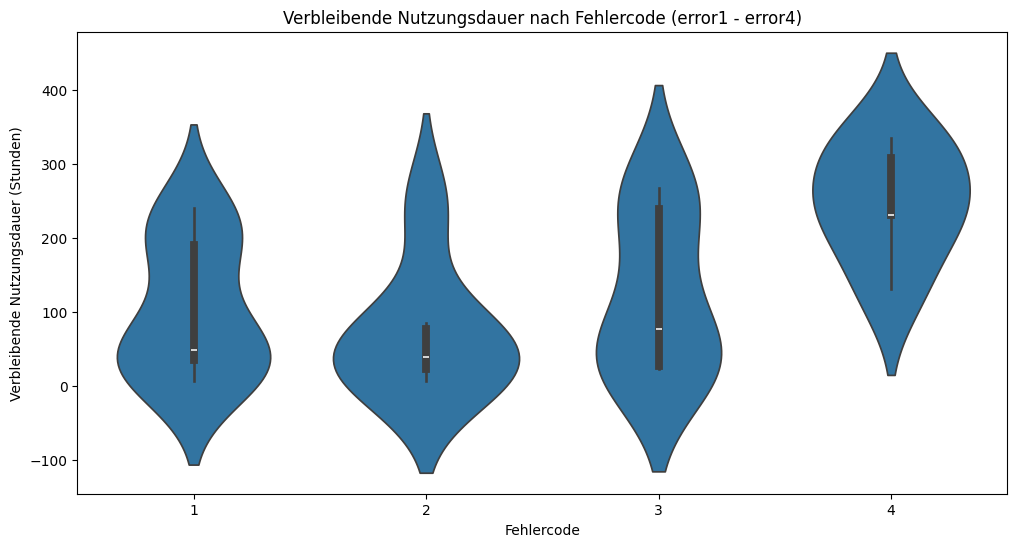

In [106]:
# Vorausgesetzt, die Spalte 'errorID' enthält die Fehlercodes
filtered_data = data[data['errorID'].isin([1, 2, 3, 4])]

plt.figure(figsize=(12,6))
sns.violinplot(x='errorID', y='time_to_next_replacement', data=filtered_data)
plt.title('Verbleibende Nutzungsdauer nach Fehlercode (error1 - error4)')
plt.xlabel('Fehlercode')
plt.ylabel('Verbleibende Nutzungsdauer (Stunden)')
plt.show()


In [107]:
import pandas as pd


# Sortieren der Daten
data = data.sort_values(by=['machineID', 'datetime'])
data['comp'].fillna('no_error', inplace=True)
data['comp'] = data['comp'].astype('category')
data['comp_label'] = data['comp'].cat.codes  # Konvertiert die Komponenten in numerische Labels

comp_mapping = dict(enumerate(data['comp'].cat.categories))
print(comp_mapping)


{0: 0, 1: 1, 2: 2, 3: 3, 4: 4}


/tmp/ipykernel_4057233/539561252.py:6: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  data['comp'].fillna('no_error', inplace=True)


{0: 0, 1: 1, 2: 2, 3: 3, 4: 4}


In [109]:
features = ['volt', 'rotate', 'pressure', 'vibration', 'age']
X = data[features]
y = data['comp_label']



In [110]:
from sklearn.model_selection import train_test_split

# Datenaufteilung in Trainings- und Testset
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, stratify=y, random_state=42)


In [111]:
from sklearn.ensemble import RandomForestClassifier

# Modellinitialisierung
model = RandomForestClassifier(n_estimators=100, random_state=42)
# Modelltraining
model.fit(X_train, y_train)


RandomForestClassifier(random_state=42)

In [112]:
# Vorhersage auf dem Testset
y_pred = model.predict(X_test)


              precision    recall  f1-score   support

           0       1.00      1.00      1.00      1748
           1       0.00      0.00      0.00         2
           2       0.00      0.00      0.00         2
           3       0.00      0.00      0.00         1
           4       0.00      0.00      0.00         2

    accuracy                           1.00      1755
   macro avg       0.20      0.20      0.20      1755
weighted avg       0.99      1.00      0.99      1755



/home/EnzoZ/.local/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/home/EnzoZ/.local/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/home/EnzoZ/.local/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


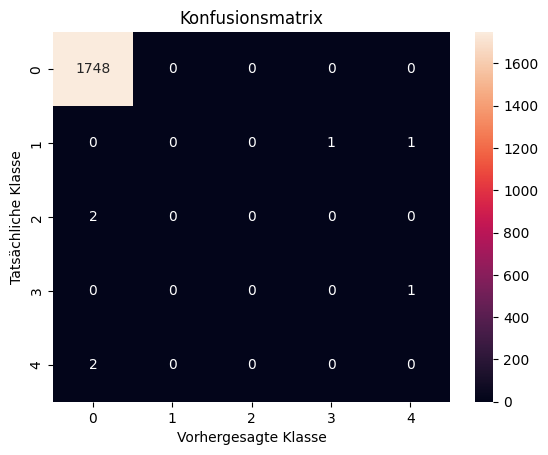

['comp_mapping.pkl']

In [115]:
from sklearn.metrics import classification_report, confusion_matrix

# Sicherstellen, dass die Kategorien Strings sind
target_names = [str(category) for category in data['comp'].cat.categories]

# Klassifikationsbericht
print(classification_report(y_test, y_pred, target_names=target_names))


# Konfusionsmatrix
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np

cm = confusion_matrix(y_test, y_pred)
sns.heatmap(cm, annot=True, fmt='d', xticklabels=data['comp'].cat.categories, yticklabels=data['comp'].cat.categories)
plt.ylabel('Tatsächliche Klasse')
plt.xlabel('Vorhergesagte Klasse')
plt.title('Konfusionsmatrix')
plt.show()

import joblib

# Modell speichern
joblib.dump(model, 'comp_replacement_model.pkl')
joblib.dump(comp_mapping, 'comp_mapping.pkl')


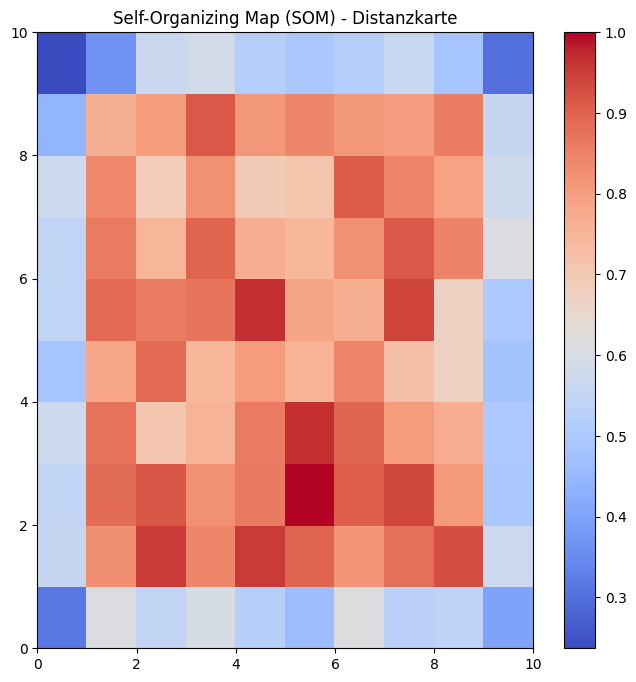

In [116]:
from minisom import MiniSom

features = ['volt', 'rotate', 'pressure', 'vibration', 'age']

# Trainings- und Testdaten splitten
X = data[features]
y = data['time_to_next_replacement']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# SOM initialisieren und trainieren
som = MiniSom(x=10, y=10, input_len=len(features), sigma=0.3, learning_rate=0.5)
#som.random_weights_init(X_train)
som.train_random(X_train.values, num_iteration=100)

# Visualisieren der Gewichte
plt.figure(figsize=(8, 8))
plt.pcolor(som.distance_map().T, cmap='coolwarm')  # Distanzkarte
plt.colorbar()
plt.title("Self-Organizing Map (SOM) - Distanzkarte")
plt.show()


Kann vermulich weg ;) ->

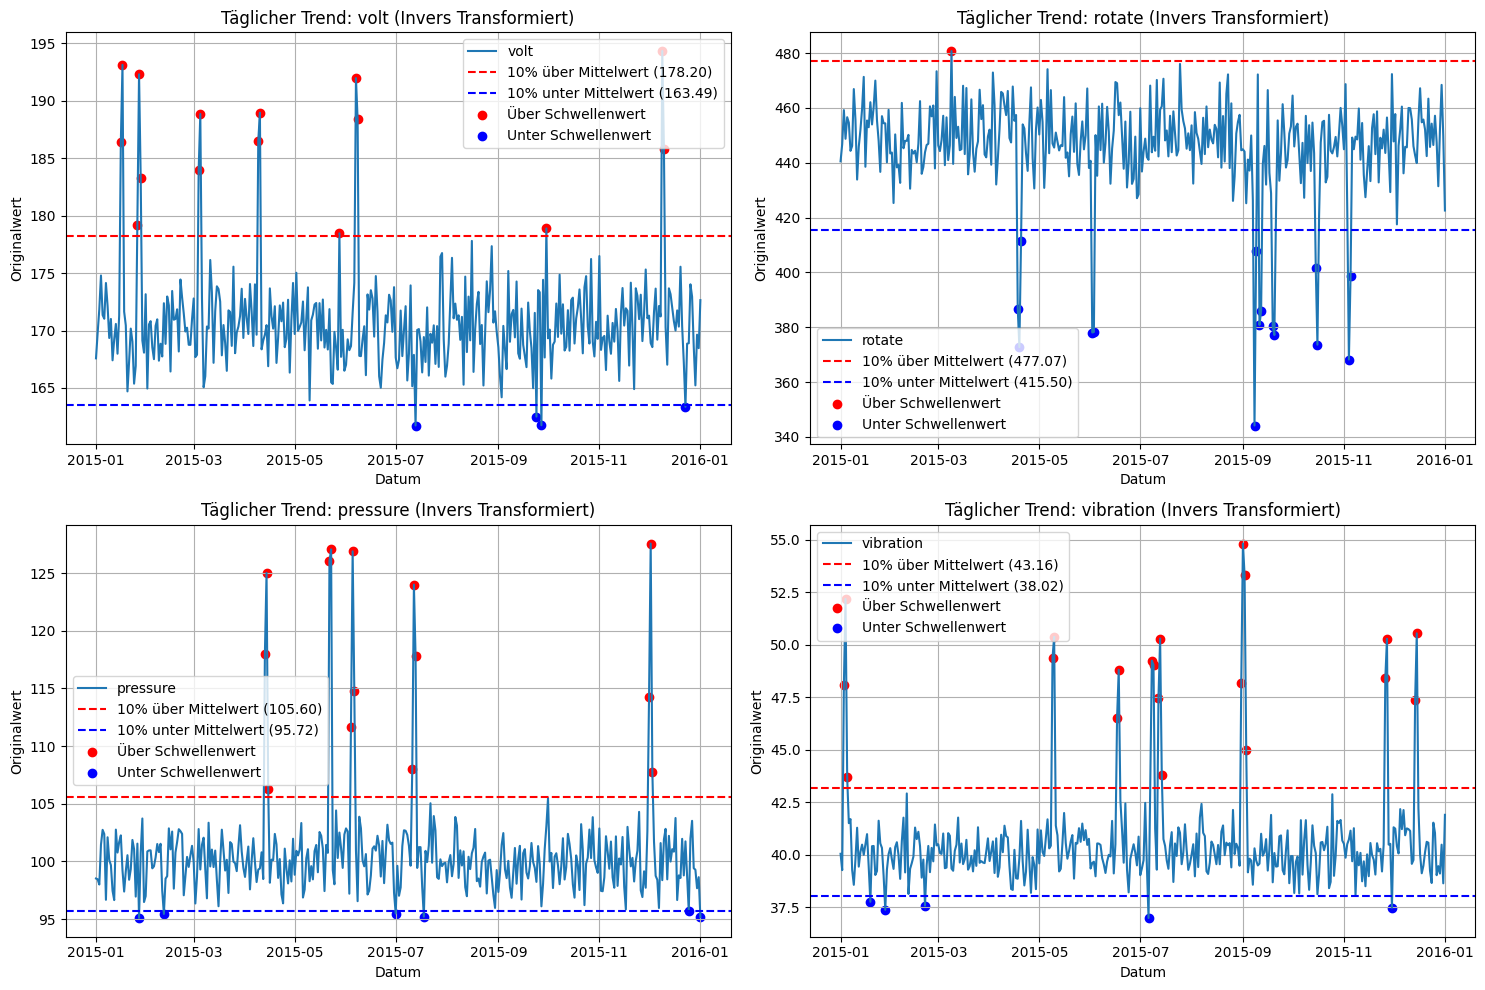

In [122]:
# Visualisierung der Trends mit den invers transformierten Grenzwerten
fig, axes = plt.subplots(2, 2, figsize=(15, 10))
for ax, (col, lower_threshold, upper_threshold) in zip(
    axes.flat, 
    zip(daily_aggregated.columns, inverse_lower_thresholds, inverse_upper_thresholds)
):
    inverse_scaled_data.plot(y=col, ax=ax, title=f"Täglicher Trend: {col} (Invers Transformiert)", legend=False)
    ax.axhline(upper_threshold, color='red', linestyle='--', label=f"10% über Mittelwert ({upper_threshold:.2f})")
    ax.axhline(lower_threshold, color='blue', linestyle='--', label=f"10% unter Mittelwert ({lower_threshold:.2f})")
    
    # Highlight datapoints above the threshold
    above_threshold = inverse_scaled_data[inverse_scaled_data[col] > upper_threshold]
    below_threshold = inverse_scaled_data[inverse_scaled_data[col] < lower_threshold]
    ax.scatter(above_threshold.index, above_threshold[col], color='red', label='Über Schwellenwert')
    ax.scatter(below_threshold.index, below_threshold[col], color='blue', label='Unter Schwellenwert')
    
    ax.legend()

# Achsentitel hinzufügen
for ax in axes.flat:
    ax.set_xlabel("Datum")
    ax.set_ylabel("Originalwert")
    ax.grid(True)

plt.tight_layout()
plt.show()


In [157]:
# Prüfe auf Datenpunkte, die die invers transformierten Grenzwerte überschreiten
for col, lower_threshold, upper_threshold in zip(
    daily_aggregated.columns, inverse_lower_thresholds, inverse_upper_thresholds
):
    error_data = inverse_scaled_data[
        (inverse_scaled_data[col] < lower_threshold) | (inverse_scaled_data[col] > upper_threshold)
    ]
    if not error_data.empty:
        print(f"Fehlerhafte Datenpunkte für '{col}':")
        display(error_data.head(5))  # Zeige nur die ersten 10 Zeilen
        print("\n")

# Prüfe, ob tatsächlich Fehlercodes vorliegen (wenn 'failure' != 0) und zeige die betroffenen Werte an
error_data_failure = data[
    (data['volt'] < lower_thresholds['volt']) | (data['volt'] > upper_thresholds['volt'])
]
error_data_failure = error_data_failure[error_data_failure['failure'] != 0]

# Rücktransformation für die fehlerhaften Daten
if not error_data_failure.empty:
    inversed_error_data = pd.DataFrame(
        scaler_subset.inverse_transform(error_data_failure[['volt', 'rotate', 'pressure', 'vibration']]),
        columns=['volt', 'rotate', 'pressure', 'vibration'],
        index=error_data_failure.index
    )
    inversed_error_data['comp'] = error_data_failure['comp'].map(comp_mapping)
    print("Fehlerhafte Datenpunkte mit Fehlercodes:")
    display(inversed_error_data.head(5))  # Zeige nur die ersten 10 Zeilen
else:
    print("Keine fehlerhaften Datenpunkte mit Fehlercodes gefunden.")
    # Evaluation of the quality: Check how many of the real errors are found with the thresholds

print("Anzahl der tatsächlichen Fehlercodes: ", len(data[data['failure'] != 0]))
print("Anzahl der Fehlercodes, die mit den Schwellenwerten gefunden wurden: ", len(error_data_failure))

Fehlerhafte Datenpunkte für 'volt':


,volt,rotate,pressure,vibration
date,,,,
2015-01-16,186.442784,438.538113,102.261363,40.498463
2015-01-17,193.136405,455.412049,99.233100,40.985994
2015-01-26,179.223233,456.998714,101.545344,40.328477
2015-01-27,192.313627,454.429161,95.096870,39.007657
2015-01-28,183.295335,454.376357,100.719850,37.381916




Fehlerhafte Datenpunkte für 'rotate':


,volt,rotate,pressure,vibration
date,,,,
2015-03-09,170.350018,480.750628,96.802947,39.346553
2015-04-18,170.166132,386.787035,100.112601,38.861059
2015-04-19,172.114828,372.754577,102.387977,39.859482
2015-04-20,167.178212,411.508537,101.485753,41.615110
2015-06-02,169.230648,378.075091,102.604734,39.610572




Fehlerhafte Datenpunkte für 'pressure':


,volt,rotate,pressure,vibration
date,,,,
2015-01-27,192.313627,454.429161,95.096870,39.007657
2015-02-11,172.377193,450.174767,95.449548,38.135889
2015-04-13,169.634449,449.025093,118.025125,39.464861
2015-04-14,170.468035,447.404212,125.026522,38.374695
2015-04-15,166.890196,467.814649,106.266485,38.328729




Fehlerhafte Datenpunkte für 'vibration':


,volt,rotate,pressure,vibration
date,,,,
2015-01-03,171.862244,459.204742,97.998233,48.074091
2015-01-04,174.792428,448.743201,101.452266,52.190268
2015-01-05,171.349797,456.620958,102.741911,43.692423
2015-01-19,170.443004,462.081870,99.159579,37.763100
2015-01-28,183.295335,454.376357,100.719850,37.381916




Fehlerhafte Datenpunkte mit Fehlercodes:


,volt,rotate,pressure,vibration,comp
96,179.303153,499.777962,111.833028,52.383097,4
97,179.303153,499.777962,111.833028,52.383097,1
1539,198.257975,456.862342,89.333995,38.671900,1
2620,180.050801,346.362480,105.661164,39.218055,2
4061,187.673963,493.005160,105.334392,53.963961,1


Anzahl der tatsächlichen Fehlercodes:  11
Anzahl der Fehlercodes, die mit den Schwellenwerten gefunden wurden:  11
